### The Dataset is stored in the ```dataset``` folder 
downloaded from ```https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
### Start by importing all the required libraries

In [1]:
"""
Python 3.8.5
Tensorflow 2.3.1
Keras 2.4.3
conda 4.9.0
wordcloud 1.8.0
"""
import configparser
import math
import datetime
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re

"""
Which dataset to use:
1 = IMDB
2 = Sentiment140
"""

DATASET = 1



############ SENTIMENT MODEL TRAINING PARAMETERS ################################
DIMENSION = 300
LEARNING_RATE = 1e-5
BATCH_SIZE = 128
EPOCHS = 20
#################################################################################


############ DATA SPLIT PERCENTAGE ##############################################
TRAINING_SPLIT = 0.80
#################################################################################


############ DATAFILE IS DOWNLOADED (for fresh download set this to False) ######
DATASET_DOWNLOADED = True
LOAD_FROM_FILE = True
#################################################################################


############ NEED TO LIMIT THIS TO 60000 TO ENABLE BUILDING OF DISTANCE MATRIX ##
USE_MAX_VOCABULARY_SIZE = False
MAX_VOCABULARY_SIZE = 50000
#################################################################################

### Read and set global variables 

In [2]:
config = configparser.ConfigParser()
config.read('config/main.conf')

if DATASET == 1:
    set_dataset = "imdb"
if DATASET == 2:
    set_dataset = "s140"

DATASET_URL = (config[set_dataset]['DATASET_URL'])
DATASET_TAR_FILE_NAME = config[set_dataset]['DATASET_TAR_FILE_NAME']
TAR_FILE_PATH = config[set_dataset]['TAR_FILE_PATH']
CLEAN_DATA_FILE_NAME = config[set_dataset]['CLEAN_DATA_FILE_NAME']

DATASET_FOLDER = config[set_dataset]['DATASET_FOLDER']
FOLDER_NAME = config[set_dataset]['FOLDER_NAME']
DATA_SET = config[set_dataset]['DATA_SET']

MODEL_SAVE_DIRECTORY = config[set_dataset]['MODEL_SAVE_DIRECTORY']
TRAINING_SAVE_DIRECTORY = config[set_dataset]['TRAINING_SAVE_DIRECTORY']
 

MODEL_SAVE_PATH = config[set_dataset]['MODEL_SAVE_PATH']
CHECKPOINT_PATH = config[set_dataset]['CHECKPOINT_PATH']
CHECKPOINT_DIR = config[set_dataset]['CHECKPOINT_DIR']

TRAINING_HISORTY_SAVE_PATH = config[set_dataset]['TRAINING_HISORTY_SAVE_PATH']

COUNTER_FITTED_VECTORS = config[set_dataset]['COUNTER_FITTED_VECTORS']
GLOVE_EMBEDDINGS = config[set_dataset]['GLOVE_EMBEDDINGS']

GLOVE_EMBEDDINGS_FILE = config[set_dataset]['GLOVE_EMBEDDINGS_FILE']
COUNTER_FITTED_EMBEDDINGS_FILE = config[set_dataset]['COUNTER_FITTED_EMBEDDINGS_FILE']
 



### Create the model save directory

In [3]:
if not os.path.exists(MODEL_SAVE_DIRECTORY):
    os.makedirs(MODEL_SAVE_DIRECTORY)
    
if not os.path.exists(TRAINING_SAVE_DIRECTORY):
    os.makedirs(TRAINING_SAVE_DIRECTORY)


# Download the dataset and extract contents to correct directories

In [4]:
from manny_train import file_download_extraction as fde


from_folder =""
to_folder = DATA_SET

if DATASET_DOWNLOADED:
    print("If you want to download a fresh copy of the data set,")
    print("make sure the variable DATASET_DOWNLOADED is set to False")
elif DATASET == 1:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_tar_file(TAR_FILE_PATH, DATASET_FOLDER)
    
    directories_in_dataset_folder = fde.get_directory_name(DATASET_FOLDER)

    if len(directories_in_dataset_folder) == 1:
        from_folder=DATASET_FOLDER+"/"+directories_in_dataset_folder[0]
        fde.rename_folder(from_folder, to_folder)
    else:
        print("ERROR!")
        print(DATASET_FOLDER," folder has too many sub directories!")
        print("Make sure ", DATASET_FOLDER, " is empty before downloading fresh dataset file")
elif DATASET == 2:
    DATASET_DOWNLOADED = True
    fde.download(DATASET_URL, dest_folder=DATASET_FOLDER)
    fde.extract_zip_file(TAR_FILE_PATH, DATASET_FOLDER)
    fde.rename_s140_file(DATASET_FOLDER)
    


If you want to download a fresh copy of the data set,
make sure the variable DATASET_DOWNLOADED is set to False



# Load dataset:
## We have 2 options: 
#### 1) Load data from a fresh download, or
#### 2) Load a previously saved dataset 


## 1) Load data from a fresh download

In [5]:
from manny_train import data_loading as process

data_frame = pd.DataFrame
if DATASET == 1:
    data_frame  = process.process_dataset_IMDB(DATA_SET)
elif DATASET == 2:
    data_frame = process.process_dataset_Sentiment140(DATA_SET)
else:
    print("Please specify which dataset you want to work with...")

# save the cleaned dataset
data_frame.to_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE_NAME, index = False)
print("Saved dataset to: ", DATASET_FOLDER+"/"+CLEAN_DATA_FILE_NAME)
    
# randomise dataframe
data_frame = data_frame.sample(frac = 1, random_state = 7) 

# show the first few rows of the datasaet
data_frame.head()


Creating dataset, please wait ...
Normalizing dataset, please wait...
Dataset created!

Saved dataset to:  imdb_dataset/IMDB_clean_data.csv


,sentiment,text
11359,1,at first i hadn't read the novel so far and i...
9729,0,the fact that this movie has been entitled to ...
15270,0,this movie would receive a much higher vote fr...
15015,1,i had no expectations never saw previews for m...
16391,1,this is an excellent movie that tackles the is...


## 2) Load a previously saved dataset

In [6]:
# load the clean dataset from .csv file
dtypes = {'sentiment': 'int', 'text': 'str'}
data_frame = pd.read_csv(DATASET_FOLDER+"/"+CLEAN_DATA_FILE_NAME) # make sure we import both columns as str

# randomise dataframe
data_frame = data_frame.sample(frac = 1, random_state = 7) 

### Split the dataset into train and test, then convert each to a Keras Dataset format

In [14]:

# split into test and train datsets
train_data_raw, test_data_raw = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)


# convert to keras Dataset (TensorSliceDataset) 
train_data = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train_data_raw['text'].values, tf.string),
            tf.cast(train_data_raw['sentiment'].values, tf.int64)
        )
    )
)

test_data = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test_data_raw['text'].values, tf.string),
            tf.cast(test_data_raw['sentiment'].values, tf.int64)
        )
    )
)

# for creating vocabulary, we just need the string, so discard the sentiment value 
text_dataset =  train_data.map(lambda string_text, sentiment: string_text)


tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

## Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 25,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

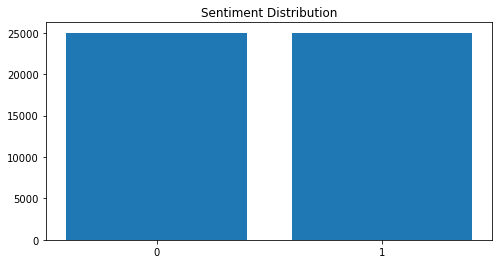

In [8]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xticks(val_count.index)
plt.title("Sentiment Distribution")

### Clean dataset: this is the pre-processing callback function used by ```TextVectorization```

## Wordcloud of ```positive``` sentiments

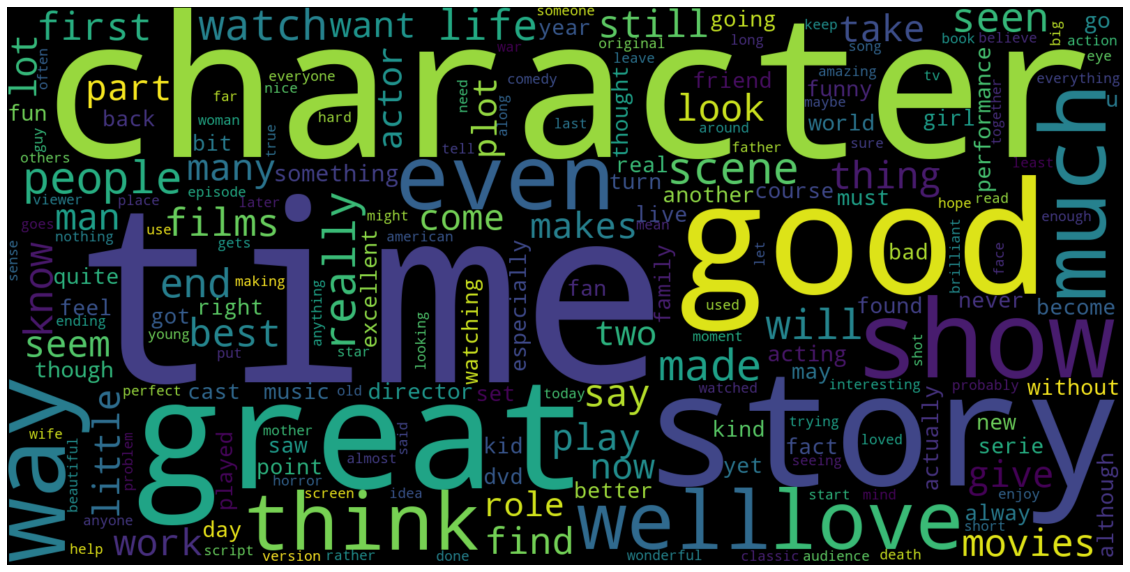

In [9]:
# add aditional stopwords
STOPWORDS.add("film")
STOPWORDS.add("movie")
STOPWORDS.add("one")
STOPWORDS.add("see")
STOPWORDS.add("make")

plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Wordcloud of ```negative``` sentiments

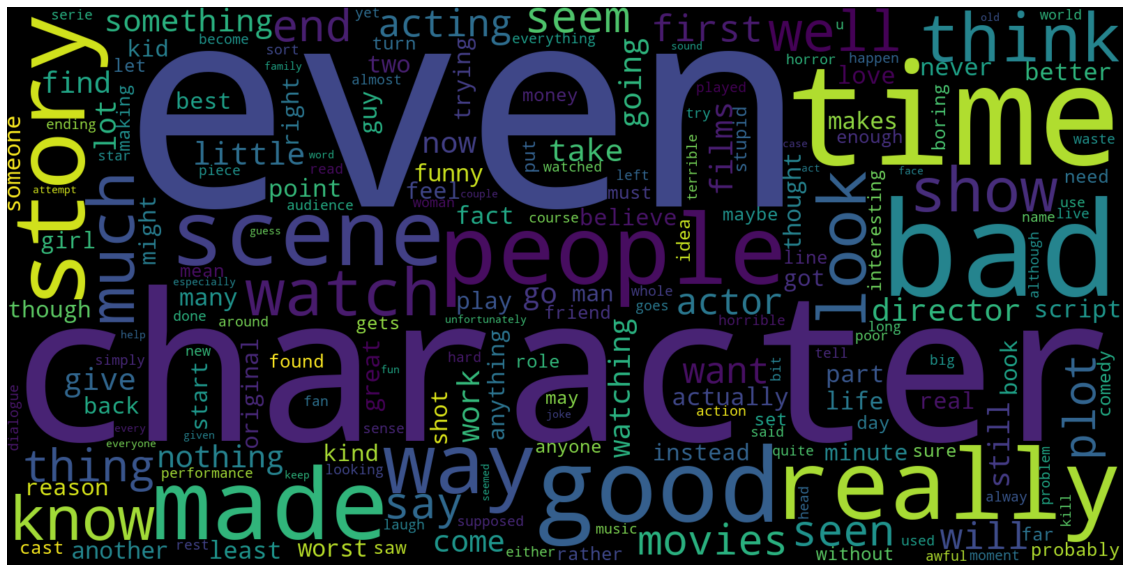

In [10]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [39]:
import string


def normlize_data(text):
    
    # print("pre-processing data ...")
    
    # define regex to use for replacements
    html_regex = '<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});' # remove all html tags
    url_regex = 'https?:\/\/\S+\b|www\.(\w+\.)+\S*'
    twitter_username_regex = "@\w+" # twitter username
    html_amp_start_regex = "&\w+"  # remove html entities starting with a &
    smiley_regex = "[8:=;]['`\-]?[)dD]+|[)dD]+['`\-]?[8:=;]"
    lol_face_regex = "[8:=;]['`\-]?p+"
    sad_face_regex = "[8:=;]['`\-]?\(+|\)+['`\-]?[8:=;]"
    neutral_face_regex = "[8:=;]['`\-]?[\/|l*]"
    forward_slash_regex = "/" # add space around forward slash
    heart_regex = "<3" # heart emoji
    numbers_regex = "[-+]?[.\d]*[\d]+[:,.\d]*" # remove numbers with signs e.g. -2, +3 etc..
    hash_tag_regex = "#\w+"
    repeated_punctuation_regex = "([!?.]){2,}" # e.g. replace ?????? to ?
    remove_numbers_regex = '[0-9]+' # remove all numbers
 
    # remove punctuation
    punctuation = string.punctuation
    punctuation = punctuation.translate({ord(i):None for i in "'"}) # keep the apostrophe, but remove all other punctuation
    remove_punctuation = f'[{re.escape(punctuation)}]'
    
    result = tf.strings.lower(text)
    result = tf.strings.strip(result) # remove leading and trailing spaces
     
    # make sure to remove html tags second
    result = tf.strings.regex_replace(result, html_regex, '')
     
    # remove any URLs
    result = tf.strings.regex_replace(result, url_regex, ' ') # url 
    result = tf.strings.regex_replace(result, twitter_username_regex, ' ') # twitetr user names 
    result = tf.strings.regex_replace(result, html_amp_start_regex, ' ') # any html entity that starts with an &
    result = tf.strings.regex_replace(result, smiley_regex, ' ') # remove any smilies/emojis in the text
    result = tf.strings.regex_replace(result, lol_face_regex, ' ') # lolface emoji
    result = tf.strings.regex_replace(result, sad_face_regex, ' ') # sad face emoji
    result = tf.strings.regex_replace(result, neutral_face_regex, ' ') # face emoji
    result = tf.strings.regex_replace(result, forward_slash_regex, r' / ') # add space around forward slash
    result = tf.strings.regex_replace(result, heart_regex, ' ') # remove heart emoji
    result = tf.strings.regex_replace(result, numbers_regex, ' ') # remove numbers e.g. -3, 2, 8, +8 etc..
    result = tf.strings.regex_replace(result, hash_tag_regex, ' ') # remove hashtags
    result = tf.strings.regex_replace(result, repeated_punctuation_regex, r'\1 ') # replace any repeated puctuation with single occurance
    result = tf.strings.regex_replace(result, remove_numbers_regex, ' ') # finally remove all numbers
    
    # then remove punctuation at the very end
    result = tf.strings.regex_replace(result, remove_punctuation, '')
    
    #result = tf.strings.strip(result)
    
    # print("Done!")
    return result



In [31]:
print("Training Data:\t",len(train_data), "\t\t% datapoints in train dataset:\t", math.ceil(TRAINING_SPLIT * 100),"%")
print("Test Data:\t",len(test_data), "\t\t% datapoints in test dataset:\t", math.ceil((1 - TRAINING_SPLIT) * 100) ,"%")


Training Data:	 40000 		% datapoints in train dataset:	 80 %
Test Data:	 10000 		% datapoints in test dataset:	 20 %


## Examine the training and test data sets

### Training dataset

In [32]:
print("Number of data points: ",len(train_data))
[t for t in train_data.take(1)]

Number of data points:  40000


[(<tf.Tensor: shape=(), dtype=string, numpy=b"ingrid bergman is a temporarily impoverished polish countess in s paris who finds herself pursued by france's most popular general and a glamorous count  and that's on top of being engaged to a shoe magnate  such is the failproof premise that entrains one of the most delirious plots in movie history  there are backroom political machinations by the general's handlers  a downed balloonist and ecstatic bastille day throngs  but the heart of this gorgeously photographed film is the frantic upstairs  downstairs intrigues involving randy servants and only slightly more restrained aristocrats  yes  it's rules of the game redux  before it's all over even gaston modot  the jealous gamekeeper in rules  puts in an appearance  as a gypsy capo  no less  things happen a little too thick and fast toward the end  resulting in some confusion for this nonfrench speaker  but what the heck  elena and her men is another deeply humane renoir masterpiece ">,
  <

### Testing dataset

In [33]:
print("Number of data points: ",len(test_data))
[t for t in test_data.take(1)]

Number of data points:  10000


[(<tf.Tensor: shape=(), dtype=string, numpy=b"at first  i hadn't read the novel so far and i hadn't hear anything about the author yet  but as i casually saw this movie  i was totally captive by the story  already as the jewish watchman primary said  that he knows no one  who have a bad conscience about the war except from howard w  campbell junior  was such amazing objective and dissociates from simply moralizing the war  terrific  and the fictitious story about the most effective spy for the usa in wwii who have lost everything  that was important for his life  is wonderful emotional transcribed  this is the best story about the duality of humanity  i've ever heard about  the questions  this movie is introducing  are in my opinion very important for our society  when does someone bear the guilt of something  what is guilt  who is a hero and who is a felon  what is important in our life  can you live without paying attention to the political changes  is the protagonist guilty or not  

# Tokenization of training data
- We will use the new ```TextVectorization``` Keras class to tokenize our training data
- ```max_tokens``` i.e. limit vocabulary to this size 
- ```output_sequence_length``` i.e. limit length of text sequence

<center>
<img src="images/tokenization-manning.png">
</center>
  
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


#### We will use ```TextVectorization``` to index the vocabulary found in the dataset. Later, we'll use the same layer instance to vectorize the samples.

#### 1) Our layer will only consider the top $ 50,000 $ words
#### 2) we will truncate or pad sequences to be actually $ 300 $ tokens long
#### 3) we will pre-process our text data by defining a callback function: ```normalize_data```

In [40]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization # in Tensorflow 2.1 and above


vectorizer = TextVectorization(
    standardize=normlize_data, 
    max_tokens=50000, 
    output_mode='int',
    output_sequence_length=300)

# convert from Pandas Series to numpy array
#num_text_array = data_frame.text.to_numpy() 

# batch the data
#text_ds = tf.data.Dataset.from_tensor_slices(num_text_array).batch(128)

# build vocabulary, will also run the normalize_data() 
vectorizer.adapt(text_dataset.batch(64))



## Create a dictionary, mapping words to their indices
#### Store vocabulary in a list ```vocab```, and reverse lookup in a dictionary ```word_index```

In [106]:

vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

print("length of vocab: %d, length of word_index:  %d" % (len(vocab),len(word_index)))

length of vocab: 50000, length of word_index:  50000


### Lookup word using the vocabulary list and word_index

In [95]:
index_of_word = word_index['movie']
print("value of index_of_word is: ",index_of_word)

word_in_vocab = vocab[index_of_word]
print("Word in vocab at index:",index_of_word, " is:", word_in_vocab)


test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

value of index_of_word is:  17
Word in vocab at index: 17  is: movie


[2, 1235, 1738, 20, 2, 13904]

### Display the top 5 most frquent words

In [61]:
vectorizer.get_vocabulary()[:5] # index 0 reserved for padding token and index 1 is reserved for out of vocabulary (UNK) words

['', '[UNK]', 'the', 'and', 'a']

### Example vectorized sentence:
#### the word ```ghjghj``` is out of vocaabulary (oov) and hence coded as 1 i.e. 'UNK'

In [74]:

vectorizer([['the cow jumped over the moon ghjghj']]).numpy()[0, :7]


array([   2, 6563, 4877,  127,    2, 1760,    1])

## Load pre-trained word GloVe embeddings

#### Create a dict mapping words (strings) to their NumPy vector representation

In [96]:

embeddings_index= {}
print("Loading embeddings model to dictionary, please wait...")
with open(GLOVE_EMBEDDINGS, 'r', encoding="utf8") as f:
    for line in f:
        values = line.strip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Finished!")
print('Found %s word vectors in model.' %len(embeddings_index))


Loading embeddings model to dictionary, please wait...
Finished!
Found 2196007 word vectors in model.


#### Now prepare a corresponding embedding matrix that we can use in a Keras ```Embedding``` layer

In [105]:
num_tokens = len(vocab) + 1
embedding_dim = 300
hits = 0
misses = 0


embedding_matrix = np.zeros((num_tokens, embedding_dim))
count = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:
        
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d not found)" % (hits, misses))
print("Embedding matrix shape: ",  (embedding_matrix.shape))

Converted 41844 words (8156 misses)
Embedding matrix shape:  (50001, 300)


#### Now we need to load the pre-traiined GloVe embeddings inot an ```Embedding``` layer
##### (We set ```training=False``` so to keep the embeddings fixed i.e. we do NOT want them to update during training)

In [300]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)


## Build our model

In [107]:
from tensorflow.keras.layers import Embedding
# def create_model():
#     # activation changed from tanh to relu
#     # make sure to add the shape parameter (the length of the sequences), otherwise the loss and val_loss wont be calculated and will show as NaN
#     inputs = keras.Input(shape=(1,), dtype=tf.string)
#     x = vectorizer(inputs)
#     embedding_sequences = embedding_layer(x)

#     x = SpatialDropout1D(0.2)(embedding_sequences)
#     x = Conv1D(64, 5, activation='relu')(x)
#     x = Bidirectional(LSTM(128, dropout=0.2))(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.5)(x)  # set dropout rate to 0.5 to prevent over-fitting
#     x = Dense(512, activation='relu')(x)

#     predictions = Dense(1, activation='sigmoid')(x)
#     model =  keras.Model(inputs, predictions)

#     # default learning rate is 0.001 for Adam optimizer
#     model.compile(
#         loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["acc"]
#     )
#     return model



# # Our dataset will yield samples that are strings
# dataset = tf.data.Dataset.from_tensor_slices((samples, labels)).batch(2)

# # Our model should expect strings as inputs
# inputs = keras.Input(shape=(1,), dtype="string")
# x = vectorizer(inputs)
# x = layers.Embedding(input_dim=10, output_dim=32)(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# model.compile(optimizer="adam", loss="mse", run_eagerly=True)
# model.fit(dataset)



def create_model(vectorize_layer, embedding_matrix):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer) # use vovaculary as layer in model
    model.add(tf.keras.layers.Embedding(num_tokens,
                                                  embedding_dim,
                                                  embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                                  trainable=False,
                                                  mask_zero=True))
    
    model.add(tf.keras.layers.SpatialDropout1D(0.2))
    model.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
    model.add(tf.keras.layers.Bidirectional(LSTM(128, dropout=0.2)))
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5)) # set dropout rate to 0.5 to prevent over-fitting
    model.add(tf.keras.layers.Dense(512, activation='relu'))

    # classification layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
   

    # default learning rate is 0.001 for Adam optimizer, reduced to 1e-4 here
    model.compile(
        loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["acc"]
    )
    return model



model = create_model(vectorizer, embedding_matrix)
model.summary()


# EXPORT END-TO-END MODEL
# inputs = keras.Input(shape=(1,), dtype=tf.string)
# x = vectorizer(inputs)
# outputs = model(x)
# end_to_end_model = keras.Model(inputs, outputs)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_6 (TextVe (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          15000300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

## Train our model

#### Convert our list of strings data to a NumPy arrays of integer indices (arrays are right padded)

#### We will use ```binary_crossentropy``` since we have only two possible classifications

In [108]:
batch_size = 64
epochs = 5

# callbacks
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.1, 
                                         patience=7, 
                                         verbose=1, 
                                         min_lr = 0.0001, 
                                         mode='min')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                                         save_best_only=True,
                                                         monitor='val_acc',
                                                         save_weights_only=True,
                                                         verbose=1)





print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")

hist = model.fit(train_data.batch(batch_size), epochs=epochs, validation_data=test_data.batch(batch_size),callbacks=[reduce_lr_on_plateau,checkpoint_callback] )

print("\nFinished building model!")


Training on GPU...
Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.5424 - acc: 0.7209
Epoch 00001: val_acc improved from -inf to 0.80590, saving model to ../models/checkpoints/imdb/cp.ckpt
625/625 [==============================] - 44s 70ms/step - loss: 0.5424 - acc: 0.7209 - val_loss: 0.4386 - val_acc: 0.8059
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.4270 - acc: 0.8134
Epoch 00002: val_acc improved from 0.80590 to 0.83820, saving model to ../models/checkpoints/imdb/cp.ckpt
625/625 [==============================] - 42s 68ms/step - loss: 0.4270 - acc: 0.8134 - val_loss: 0.3714 - val_acc: 0.8382
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.4002 - acc: 0.8270
Epoch 00003: val_acc improved from 0.83820 to 0.85460, saving model to ../models/checkpoints/imdb/cp.ckpt
625/625 [==============================] - 42s 67ms/step - loss: 0.4002 - acc: 0.8270 - val_loss: 0.3447 - val_acc: 0.8546
Epoch 4/5
625/625 [========

### Test the model

In [113]:
# 

p = [["In summary, it is visually impressive! Yet manages to be very bland and boring. Like Saturday cartoon level of content, with less colors, dialogue or dumb jokes. Even the way the Mandalorian walks is dull."]]
prob_positive = model.predict(p)
print("Probability this review is positive: ",prob_positive)

Probability this review is positive:  [[0.03731474]]


In [425]:
#!ls {CHECKPOINT_DIR}

model.load_weights(CHECKPOINT_PATH) # loads best weights saved during training

### Check again after loading the best weights found for the model

In [ ]:
p = [["In summary, it is visually impressive! Yet manages to be very bland and boring. Like Saturday cartoon level of content, with less colors, dialogue or dumb jokes. Even the way the Mandalorian walks is dull."]]
prob_positive = model.predict(p)
print("Probability this review is positive: %d", % prob_positive)

## Load the best weights generated

NameError: name 'model' is not defined

In [7]:

loaded = tf.saved_model.load("../models/my_imdb_model")



In [8]:
loaded

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f8a404b9580>

## Evaluate model using unseen test data

In [426]:

scores_evaluate = model.evaluate(test_data.batch(batch_size),verbose=1)
print("Accuracy: %.2f%%" % (scores_evaluate[1]*100))


157/157 [==============================] - 5s 31ms/step - loss: 0.4336 - acc: 0.8415
Accuracy: 84.15%


## Export an end to end model
#### We want our model to take as input a string of arbitrary length, rather than a sequence of indices. So that we have a more portable model, since you wouldn't have to worry about the input preprocessing pipeline.

Our vectorizer is actually a Keras layer, so it's simple:

In [427]:


# string_input = keras.Input(shape=(1,), dtype=tf.string)
# x = vectorizer(string_input)

# preds = model(x)
# end_to_end_model = keras.Model(string_input, preds)

# predict unseen negative review for the new Mandalorian TV show (4 star rating)
t_neg = [["In summary, it is visually impressive! Yet manages to be very bland and boring. Like Saturday cartoon level of content, with less colors, dialogue or dumb jokes. Even the way the Mandalorian walks is dull."]]
prob_negative = model.predict(t_neg)
#prob_recon = reconstructed_model.predict(t_neg)
print("Predicted prob of this being a positive review: ", prob_negative)

# # # predict unseen positive review for the new Mandalorian TV show (9 star rating)
# # t_pos = [["This is the Star Wars atmosphere and feeling I've been waiting for. No dumb humor, cool characters, and a story I can take seriously. I'm a big fan of what they've done with this series so far and current Star Wars filmmakers need to take notes. The cinematography is amazing. You can tell they use practicality as much as possible and CGI is used only for the obvious like spaceships and creatures etc. It's a truly remarkable balance of old and new."]]
# # prob_positive = end_to_end_model.predict(t_pos)
# # print("Predicted prob for positive review on unseen data: ", prob_positive)

# type(prob_positive)

Predicted prob of this being a positive review:  [[0.04505186]]


157/157 [==============================] - 5s 31ms/step


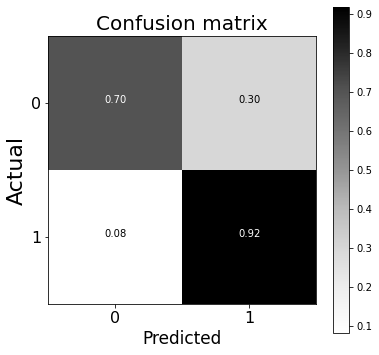

In [399]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def plot_confusion_matrix(cm, classes, title='Confusion Matrix',cmap=plt.cm.Greys, normalize=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual', fontsize=22)
    plt.xlabel('Predicted', fontsize=17)
    
    
def decode_sentiment(score):
    return 1 if score>0.5 else 0

scores_predict = model.predict(test_data.batch(batch_size),verbose=1)
y_predictions = [decode_sentiment(score) for score in scores_predict]

# add text predictions to list 
text_dataset_predictions = []
for item in test_data:
    text_dataset_predictions.append(item[1].numpy())


cnf_matrix = confusion_matrix(text_dataset_predictions, y_predictions)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=list(set(text_dataset_predictions)), title="Confusion matrix")
plt.savefig('images/imdb-confusion-matrix.png',bbox_inches='tight')
plt.show()


In [400]:
print(classification_report(text_dataset_predictions, y_predictions))

              precision    recall  f1-score   support

           0       0.89      0.70      0.79      4938
           1       0.76      0.92      0.83      5062

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.81     10000
weighted avg       0.83      0.81      0.81     10000



## Save the model and training history

In [108]:
from tensorflow.keras.models import Sequential, save_model, load_model
import pickle



# save the model outside of git directory - so we don't try and push to github
# add code to check save directory exists, if not then create it
save_model(model, MODEL_SAVE_PATH)

# save history as a dictionary in case we need to plot again later
with open(TRAINING_HISORTY_SAVE_PATH, 'wb') as file_pickle:
        pickle.dump(hist.history, file_pickle)
       


## Delete model and end_to_end_model
#### To test they reload correctly

In [110]:
# tf.saved_model.save(end_to_end_model, END_TO_END_MODEL_SAVE_PATH)
save_model(end_to_end_model, END_TO_END_MODEL_SAVE_PATH)

# del end_to_end_model
# del model

INFO:tensorflow:Assets written to: ../models/imdb/final_model/assets


In [17]:
from tensorflow.keras.models import Sequential, save_model, load_model
import pickle

end_model = load_model(END_TO_END_MODEL_SAVE_PATH, compile=True)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7f85b1b26520> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7f85abd27c40>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7f85b1b26520> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7f85abd27c40>).


In [18]:
# t_pos = [["But it is kinda hilarious, at least if you grew up on Weird Al, like I did. It's a mockumentary about his life and career, beginning with superstardom and going back to trace the origins. It's uneven in places, but some of the segments are still very funny, particularly when he goes to Japan. Although it's not quite as emotionally textured as Lost in Translation, and he doesn't find love however fleeting, he does capture in a bottle the absolutely bizarre cultural melange that is Tokyo street life."]]
# prob_positive = end_model.predict(t_pos)
# print(prob_positive)
end_model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 300)               0         
_________________________________________________________________
model (Model)                (None, 1)                 15688749  
Total params: 15,688,749
Trainable params: 15,688,749
Non-trainable params: 0
_________________________________________________________________


## Load saved model

In [75]:
import keras
from keras.models import load_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow as tf


model = load_model(MODEL_SAVE_PATH, compile = True)
  
hist = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))
#end_to_end_model = load_model("/home/mas/models/end_model.tf")






In [86]:
saved_model = keras.models.load_model(END_TO_END_MODEL_SAVE_PATH)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7fc9f5dc6310> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7fc9f5dc6520>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.engine.training.Model object at 0x7fc9f5dc6310> and <tensorflow.python.keras.saving.saved_model.load.TextVectorization object at 0x7fc9f5dc6520>).


In [87]:
type(saved_model)

tensorflow.python.keras.engine.training.Model

In [92]:
y_predict = saved_model(tf.constant(t_pos, dtype=tf.string))
print(y_predict)

tf.Tensor([[0.04654495]], shape=(1, 1), dtype=float32)


In [38]:
# predict unseen negative review for the new Mandalorian TV show (4 star rating)
t_neg = [["I'm a starwars franchise fan, and a Jon Favreau fan. I truly had great expectations when i saw the trailer. I thought that, wow, finally a spin-off with this legendary Mandalorian. Well, i'm really disappointed to discover a well directed but very weak story line, full of clichés"]]
prob_negative = end_to_end_model.predict(t_neg)
print("Predicted prob for negative review on unseen data: ", prob_negative)

# predict unseen positive review for the new Mandalorian TV show (9 star rating)
t_pos = [["Finally, this feels like the Star Wars universe. The cinematography, the atmosphere, the story line, wow! My only negative is, the episodes are too short."]]
prob_positive = end_to_end_model.predict(t_pos)
print("Predicted prob for positive review on unseen data: ", prob_positive)



Predicted prob for negative review on unseen data:  [[0.6752411]]
Predicted prob for positive review on unseen data:  [[0.6752411]]


# Create attack embeddings matrix for our vocabulary
#### (This will be used when generating attacks against the model)

In [30]:

counter_embeddings_matrix = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)


max_vocabulary_size:  60001
Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


### Shape of our vocabulary matrix

In [31]:

print(counter_embeddings_matrix.shape)


(60001, 300)


### Save our vocabulary embeddings matrix

In [33]:

# save the counter fitted embeddings for words found
full_path_to_file = "embeddings/"+COUNTER_FITTED_EMBEDDINGS_FILE
save_numpy_array_to_file(full_path_to_file, MAX_VOCABULARY_SIZE, counter_embeddings_matrix)


Saving file please wait...
Finished!
Saved file to:  embeddings/S140_counter_fitted_embeddings_60000.npy


# Save the model
we can later load it from disk

In [43]:
from keras.models import load_model
model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [44]:

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 300)          18000300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 128, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

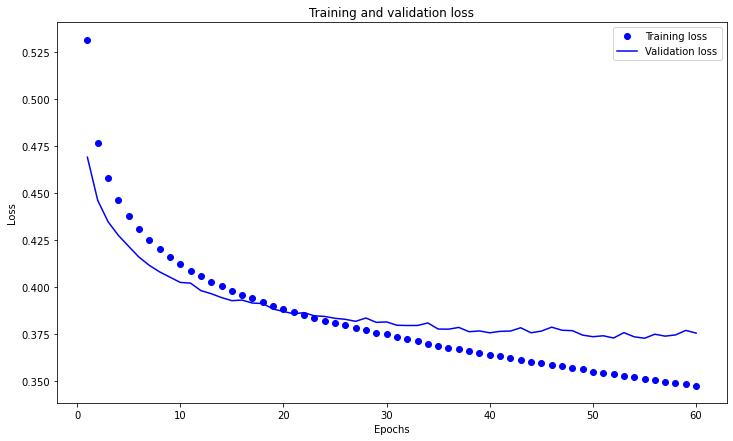

In [45]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,7))
plt.plot(epochs, loss,'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('images/S140-training-and-validation-loss.png',bbox_inches='tight')
plt.show()


<Figure size 432x288 with 0 Axes>

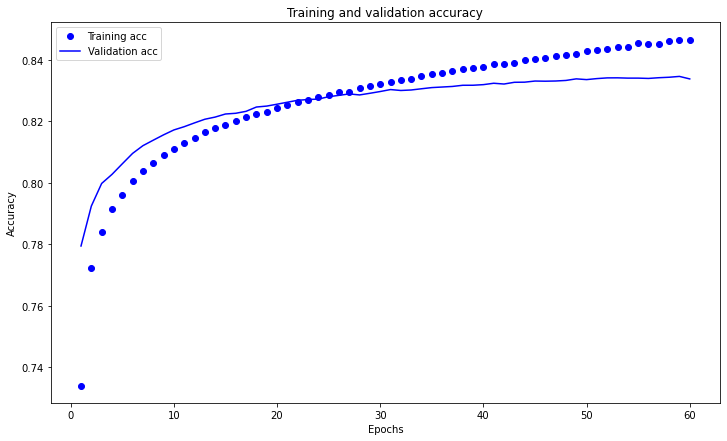

In [46]:
plt.clf()   # clear figure
plt.figure(figsize=(12,7))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('images/S140-training-and-validation-accuracy.png',bbox_inches='tight')
plt.show()


# At this point we have saved the clean dataset file, model and history of the training 
### Now we can just load the model, when we need it for generating adversarial examples against it

In [10]:
from keras.models import load_model
import pickle

model = load_model(MODEL_SAVE_PATH)
history_dict = pickle.load(open(TRAINING_HISORTY_SAVE_PATH, 'rb'))

In [6]:
from keras.preprocessing.text import text_to_word_sequence
import nltk

# def Preparing_string(text_string):
        
#         if len(text_string.strip()) == 0:
#             return None
        
#         data = [text_string]
#         df = pd.DataFrame(data, columns = ['text']) 
#         text_string = ctd.clean_and_return(df,"text")
#         text_string = text_string.text[0]
     
       
#         word2index = word_index
#         test=[]
#         for word in text_to_word_sequence(text_string):
#             test.append(word2index.get(word,0))
    
#         print("SHAPE: ", type(word2index))
#         dimension = 2560
#         results = np.zeros(dimension)
#         for _ , sequence in enumerate(test):
#             if sequence < dimension:
#                 results[sequence] = 1
    
#         #print("\nOriginal string:", text_string,"\n")
#         #print("\nIndex conversion:", test,"\n")
#         results = np.reshape(results,(1, dimension))
#        # print("\nConvert to vectors:", results,"\n")

#         return results
    
def Preparing_string(text_string, dimension = 2560):
        text_string = text_string.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation))
        text_string = text_string.translate(table)
    
        word2index = word_index
        test=[]
        for word in word_tokenize(text_string):
            test.append(word2index[word])
    
        results = np.zeros(dimension)
        for _ , sequence in enumerate(test):
            if sequence < dimension:
                results[sequence] = 1
    
        print("\nOriginal string:", text_string,"\n")
        print("\nIndex conversion:", test,"\n")
        results = np.reshape(results,(1, dimension))
        print("\nConvert to vectors:", results,"\n")
        return results






In [656]:
test_String = "I don't feel like I know the characters at all. I have no idea why the two soldiers were friends or what they had been through together. The cinematography tried so hard to make this an emotional shocking movie that it had the opposite effect. War scenes with gratuitous up close views of corpses and body parts that don't add anything to the story got old quick."

#test_prediction = Preparing_string(test_String)

print("Prediction: ",model.predict(Preparing_string(test_String, 10000)))


NameError: name 'word_tokenize' is not defined

In [360]:
print("DATA DICT: ", len(word_index))

DATA DICT:  262307


KeyError: 'reflectant'

In [49]:
counter_embeddings_matrix  = get_embeddings_matrix(COUNTER_FITTED_VECTORS, data_dictionary, DIMENSION)
#counter_dict = counter_embeddings_dictionary(COUNTER_FITTED_VECTORS)

max_vocabulary_size:  60001
Loading embeddings model to dictionary, please wait...
Finished!
Found 65713 word vectors in model.

Creating embeddings matrix ...
Finished!


In [279]:
import numpy as np
counter_embeddings_matrix = np.load(("embeddings/imdb_counter_fitted_embeddings_%d.npy" % MAX_VOCABULARY_SIZE))
#print(find_closest_embeddings(data_dictionary["movies"])[1:10])


print(type(counter_embeddings_matrix))
print(counter_embeddings_matrix.shape)

<class 'numpy.ndarray'>
(60001, 300)


60001


113

# Generate and save word distance matrix
#### l2 distance: $(x-y)^2$ expand this out and we get: $x^2 + y^2 - 2xy$ using this to calculate euclidian (l2) distance between vectors



In [162]:
def distance_matrix(matrix):
    dists = -2 * np.dot(matrix, matrix.T) + np.sum(matrix**2,    axis=1) + np.sum(matrix**2, axis=1)[:, np.newaxis]
    return dists

In [60]:
"""
THIS IS WHY WE HAVE TO REDUCE THE VOCABULARY SIZE - WE NEED TO ALLOCATE ENOUGH SPACE FOR THIS MATRIX
IF WE USE THE FULL VOCABULARY SIZE - WE WILL NOT BE ABLE TO ALLOCATE ENOUGH MEMORY FOR THE SIZE OF THE MATRIX
THAT WILL BE GENERATED
"""
square_matrix = -2 * np.dot(counter_embeddings_matrix, counter_embeddings_matrix.T)
print(len(square_matrix))

60001


In [61]:
a = np.sum(np.square(counter_embeddings_matrix), axis=1).reshape((1,-1))

In [62]:
b = a.T

In [63]:
square_matrix.shape

(60001, 60001)

In [64]:
a.shape

(1, 60001)

In [65]:
b.shape

(60001, 1)

# Save the distance matrix

In [66]:
dist = a + b + square_matrix

In [67]:
np.save(('embeddings/distance_counterfitted_embeddings_%d.npy' % MAX_VOCABULARY_SIZE), dist)

In [90]:
np.amax(dist)

2.859412738646227

In [92]:
np.amin(dist)

-8.881784197001252e-16

# Closest words in disrtance matrix, and their distances

In [91]:
from manny_train import build_embeddings as bemb

for r in range(100,105):
    source_word = r
    
    nearest_neighbour, distance_to_neighbour = bemb.closest_neighbours(source_word, dist, ret_count=5)
    
    print("Nearest Neighbours to `%s` are:" %inv_data_dictionary[source_word])
    
    for word_index, distance in zip(nearest_neighbour,distance_to_neighbour):
        print("\t--> ", inv_data_dictionary[word_index], "     ", distance)
    print("----------------------------------------------------------------\n")



Nearest Neighbours to `after` are:
	-->  subsequently       0.19739067975234348
	-->  afterward       0.21351224306351346
	-->  thereafter       0.21713814789663277
	-->  afterwards       0.22155526197445496
	-->  upon       0.23389274616020228
----------------------------------------------------------------

Nearest Neighbours to `think` are:
	-->  thought       0.15096381446318552
	-->  thoughts       0.19772474379935123
	-->  reckon       0.2158823221500985
	-->  thinks       0.25389518633056785
	-->  believe       0.27684226527503797
----------------------------------------------------------------

Nearest Neighbours to `characters` are:
	-->  personages       0.06438505936322758
	-->  character       0.07006674850581618
	-->  traits       0.11063837435466573
	-->  nature       0.17886766452615865
	-->  trait       0.21602845788842173
----------------------------------------------------------------

Nearest Neighbours to `watch` are:
	-->  surveillance       0.5249733280639659
	-->

In [71]:
dist_order = np.argsort(dist[src_word, :])[1:8]
print(dist_order)

[   19  1493   104    99   444 10300  1238]


In [267]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds


In [268]:
tf.__version__

'2.2.0'

In [276]:
# Load the IMDB reviews dataset using tfds. This is the raw data.
imdb_reviews = tfds.load('imdb_reviews')

# The IMDB dataset contains a train split and a test split; we create a separate
# handle for each.
train_raw = imdb_reviews['train']
test_raw = imdb_reviews['test']


# Once we have our handles, we format the datasets in a Keras-fit compatible
# format: a tuple of the form (text_data, label).
def format_dataset(input_data):
    return (input_data['text'], input_data['label'])

train_dataset = train_raw.map(format_dataset)
test_dataset = test_raw.map(format_dataset)

# We also create a dataset with only the textual data in it. This will be used
# to build our vocabulary later on.

text_dataset_1 = train_raw.map(lambda data: data['text'])



<MapDataset shapes: (), types: tf.string>

In [281]:
for t, i in train_dataset.take(1):
    print(t)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
